<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=300, height=300></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [0]:
import pandas as pd

In [0]:
data = pd.read_csv("./data/apples_pears.csv")

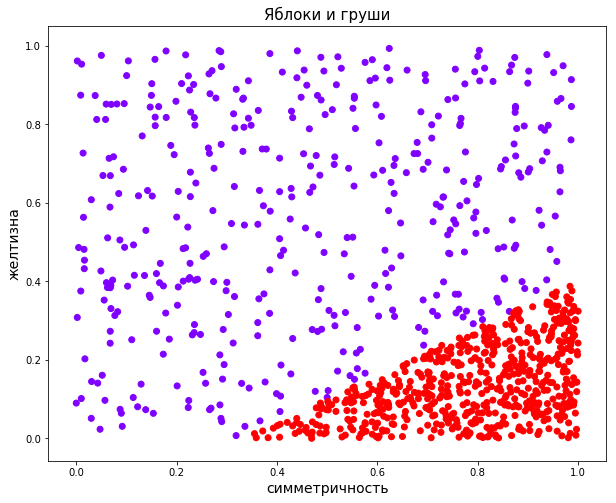

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [0]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [0]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [0]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [0]:
neuron

Sequential (
  (0): Linear (2 -> 1)
  (1): Sigmoid ()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [0]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

Variable containing:
 0.2365
[torch.FloatTensor of size 1]

Предскажем ещё необученным нейроном:

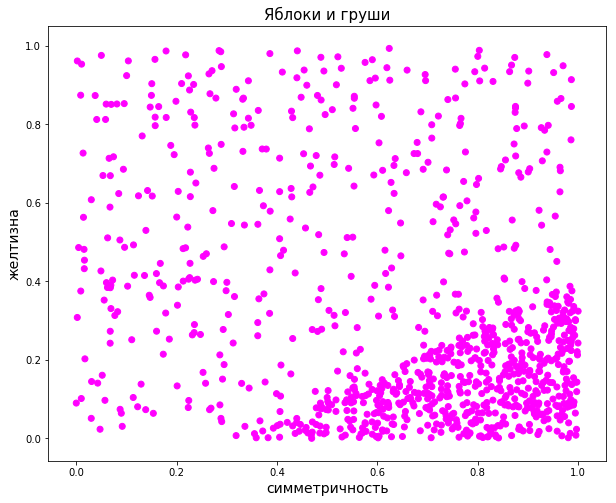

In [0]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [0]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [0]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0   
 370.9409
[torch.FloatTensor of size 1]

1   
 346.4788
[torch.FloatTensor of size 1]

2   
 322.5704
[torch.FloatTensor of size 1]

3   
 300.7311
[torch.FloatTensor of size 1]

4   
 282.0540
[torch.FloatTensor of size 1]

5   
 266.8968
[torch.FloatTensor of size 1]

6   
 254.9662
[torch.FloatTensor of size 1]

7   
 245.6300
[torch.FloatTensor of size 1]

8   
 238.2125
[torch.FloatTensor of size 1]

9   
 232.1455
[torch.FloatTensor of size 1]

10   
 227.0061
[torch.FloatTensor of size 1]

11   
 222.5011
[torch.FloatTensor of size 1]

12   
 218.4342
[torch.FloatTensor of size 1]

13   
 214.6765
[torch.FloatTensor of size 1]

14   
 211.1446
[torch.FloatTensor of size 1]

15   
 207.7842
[torch.FloatTensor of size 1]

16   
 204.5616
[torch.FloatTensor of size 1]

17   
 201.4537
[torch.FloatTensor of size 1]

18   
 198.4467
[torch.FloatTensor of size 1]

19   
 195.5310
[torch.FloatTensor of size 1]

20   
 192.7003
[torch.FloatTensor of size 1]

21   
 189.9504
[torch.


175   
 76.8858
[torch.FloatTensor of size 1]

176   
 76.6965
[torch.FloatTensor of size 1]

177   
 76.5090
[torch.FloatTensor of size 1]

178   
 76.3230
[torch.FloatTensor of size 1]

179   
 76.1388
[torch.FloatTensor of size 1]

180   
 75.9562
[torch.FloatTensor of size 1]

181   
 75.7752
[torch.FloatTensor of size 1]

182   
 75.5957
[torch.FloatTensor of size 1]

183   
 75.4177
[torch.FloatTensor of size 1]

184   
 75.2413
[torch.FloatTensor of size 1]

185   
 75.0664
[torch.FloatTensor of size 1]

186   
 74.8930
[torch.FloatTensor of size 1]

187   
 74.7210
[torch.FloatTensor of size 1]

188   
 74.5504
[torch.FloatTensor of size 1]

189   
 74.3814
[torch.FloatTensor of size 1]

190   
 74.2136
[torch.FloatTensor of size 1]

191   
 74.0474
[torch.FloatTensor of size 1]

192   
 73.8824
[torch.FloatTensor of size 1]

193   
 73.7188
[torch.FloatTensor of size 1]

194   
 73.5565
[torch.FloatTensor of size 1]

195   
 73.3956
[torch.FloatTensor of size 1]

196   
 73.2


350   
 57.8138
[torch.FloatTensor of size 1]

351   
 57.7494
[torch.FloatTensor of size 1]

352   
 57.6853
[torch.FloatTensor of size 1]

353   
 57.6213
[torch.FloatTensor of size 1]

354   
 57.5579
[torch.FloatTensor of size 1]

355   
 57.4945
[torch.FloatTensor of size 1]

356   
 57.4315
[torch.FloatTensor of size 1]

357   
 57.3687
[torch.FloatTensor of size 1]

358   
 57.3063
[torch.FloatTensor of size 1]

359   
 57.2440
[torch.FloatTensor of size 1]

360   
 57.1821
[torch.FloatTensor of size 1]

361   
 57.1204
[torch.FloatTensor of size 1]

362   
 57.0589
[torch.FloatTensor of size 1]

363   
 56.9977
[torch.FloatTensor of size 1]

364   
 56.9368
[torch.FloatTensor of size 1]

365   
 56.8762
[torch.FloatTensor of size 1]

366   
 56.8157
[torch.FloatTensor of size 1]

367   
 56.7556
[torch.FloatTensor of size 1]

368   
 56.6957
[torch.FloatTensor of size 1]

369   
 56.6360
[torch.FloatTensor of size 1]

370   
 56.5767
[torch.FloatTensor of size 1]

371   
 56.5

Обучили. Предскажем теперь:

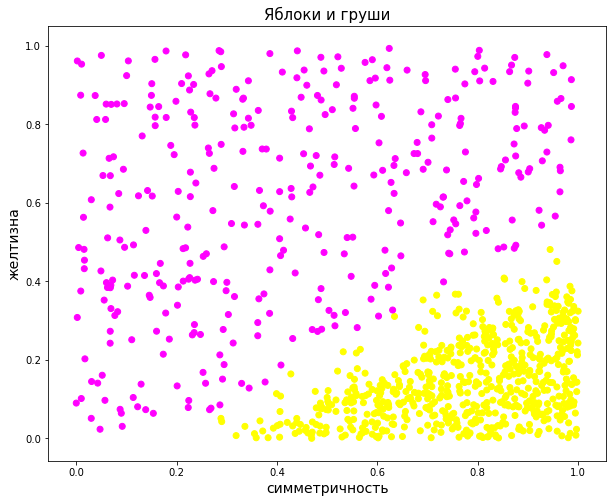

In [0]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [0]:
# Ваш код здесь (можно создавать много ячеек)

---

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

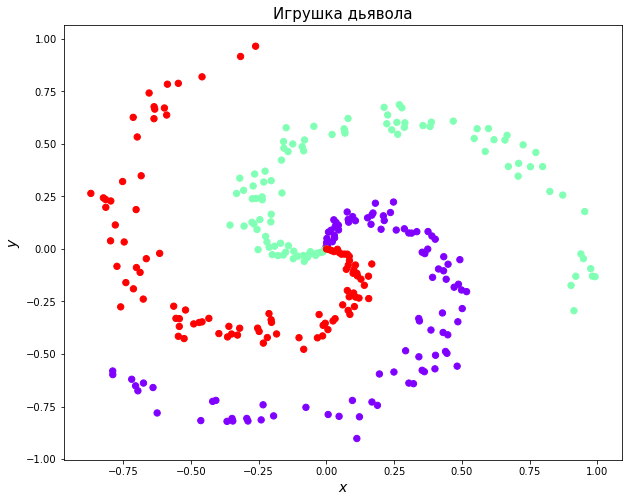

In [0]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable() (без этого градиенты не посчитать):

In [0]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [0]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [0]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

0 
 357.2256
[torch.FloatTensor of size 1]

1 
 356.7443
[torch.FloatTensor of size 1]

2 
 356.2664
[torch.FloatTensor of size 1]

3 
 355.7916
[torch.FloatTensor of size 1]

4 
 355.3206
[torch.FloatTensor of size 1]

5 
 354.8528
[torch.FloatTensor of size 1]

6 
 354.3882
[torch.FloatTensor of size 1]

7 
 353.9270
[torch.FloatTensor of size 1]

8 
 353.4688
[torch.FloatTensor of size 1]

9 
 353.0139
[torch.FloatTensor of size 1]

10 
 352.5622
[torch.FloatTensor of size 1]

11 
 352.1138
[torch.FloatTensor of size 1]

12 
 351.6683
[torch.FloatTensor of size 1]

13 
 351.2257
[torch.FloatTensor of size 1]

14 
 350.7863
[torch.FloatTensor of size 1]

15 
 350.3502
[torch.FloatTensor of size 1]

16 
 349.9168
[torch.FloatTensor of size 1]

17 
 349.4862
[torch.FloatTensor of size 1]

18 
 349.0590
[torch.FloatTensor of size 1]

19 
 348.6344
[torch.FloatTensor of size 1]

20 
 348.2126
[torch.FloatTensor of size 1]

21 
 347.7941
[torch.FloatTensor of size 1]

22 
 347.3780
[torch


181 
 303.7340
[torch.FloatTensor of size 1]

182 
 303.5471
[torch.FloatTensor of size 1]

183 
 303.3607
[torch.FloatTensor of size 1]

184 
 303.1752
[torch.FloatTensor of size 1]

185 
 302.9904
[torch.FloatTensor of size 1]

186 
 302.8058
[torch.FloatTensor of size 1]

187 
 302.6225
[torch.FloatTensor of size 1]

188 
 302.4394
[torch.FloatTensor of size 1]

189 
 302.2571
[torch.FloatTensor of size 1]

190 
 302.0756
[torch.FloatTensor of size 1]

191 
 301.8947
[torch.FloatTensor of size 1]

192 
 301.7142
[torch.FloatTensor of size 1]

193 
 301.5347
[torch.FloatTensor of size 1]

194 
 301.3556
[torch.FloatTensor of size 1]

195 
 301.1772
[torch.FloatTensor of size 1]

196 
 300.9995
[torch.FloatTensor of size 1]

197 
 300.8224
[torch.FloatTensor of size 1]

198 
 300.6458
[torch.FloatTensor of size 1]

199 
 300.4700
[torch.FloatTensor of size 1]

200 
 300.2949
[torch.FloatTensor of size 1]

201 
 300.1203
[torch.FloatTensor of size 1]

202 
 299.9463
[torch.FloatTensor


360 
 278.4590
[torch.FloatTensor of size 1]

361 
 278.3530
[torch.FloatTensor of size 1]

362 
 278.2476
[torch.FloatTensor of size 1]

363 
 278.1425
[torch.FloatTensor of size 1]

364 
 278.0373
[torch.FloatTensor of size 1]

365 
 277.9326
[torch.FloatTensor of size 1]

366 
 277.8283
[torch.FloatTensor of size 1]

367 
 277.7242
[torch.FloatTensor of size 1]

368 
 277.6204
[torch.FloatTensor of size 1]

369 
 277.5170
[torch.FloatTensor of size 1]

370 
 277.4138
[torch.FloatTensor of size 1]

371 
 277.3110
[torch.FloatTensor of size 1]

372 
 277.2082
[torch.FloatTensor of size 1]

373 
 277.1059
[torch.FloatTensor of size 1]

374 
 277.0040
[torch.FloatTensor of size 1]

375 
 276.9023
[torch.FloatTensor of size 1]

376 
 276.8008
[torch.FloatTensor of size 1]

377 
 276.6997
[torch.FloatTensor of size 1]

378 
 276.5988
[torch.FloatTensor of size 1]

379 
 276.4982
[torch.FloatTensor of size 1]

380 
 276.3979
[torch.FloatTensor of size 1]

381 
 276.2979
[torch.FloatTensor

In [0]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

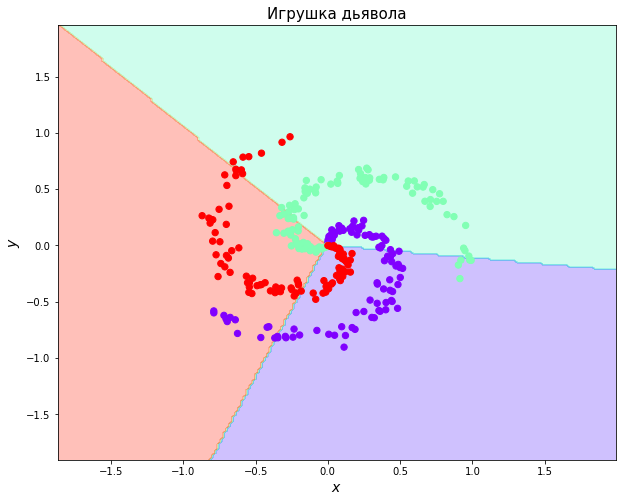

In [0]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

In [0]:
# Ваш код здесь (можно (и нужно) создавать несколько ячеек)

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*